In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import json
from tqdm import tqdm
from os.path import expanduser
from IPython.display import display, HTML
from pyathena import connect
from pyathena.pandas_cursor import PandasCursor
from joblib import Parallel, delayed
import folium
from math import radians, cos, sin, asin, sqrt
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
%matplotlib inline

In [ ]:
cursor = connect(profile_name="abhinav.sunderrajan",
                 s3_staging_dir='s3://data-science-athena-challenge/athena-output/',
                 schema_name='prophesea_staging',
                 region_name='eu-west-2',
                 work_group="data-candidate-1",
                 cursor_class=PandasCursor).cursor()

In [ ]:
query="select count(*) from vessel_temp"
vessel_temp = cursor.execute(query).as_pandas()
vessel_temp.head()

In [2]:
ais = pd.read_csv("ship_5103974.csv")
ais=ais[["movementdatetime","movestatus","latitude","longitude"]]
print(ais.shape)
ais.drop_duplicates(inplace=True)
print(ais.shape)
ais.sort_values(by="movementdatetime", inplace=True)
ais.reset_index(drop=True,inplace=True)

(41218, 4)
(24699, 4)


In [3]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6372.8
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))
    return R * c


In [4]:
ais["movementdatetime"] = pd.to_datetime(ais["movementdatetime"])
ais["prev_time"] = ais.movementdatetime.shift(1)
ais["prev_latitude"] = ais.latitude.shift(1)
ais["prev_longitude"] = ais.longitude.shift(1)
ais["time_interval"] = (ais["movementdatetime"] -
                        ais["prev_time"]).apply(lambda x: x.seconds)
ais["distance"] = ais.apply(lambda row: haversine(
    row["latitude"], row["longitude"], row["prev_latitude"], row["prev_longitude"]), axis=1)
ais["speed"] = ais["distance"]*3600/ais["time_interval"]
#ais.dropna(inplace=True)
ais.head()

,movementdatetime,movestatus,latitude,longitude,prev_time,prev_latitude,prev_longitude,time_interval,distance,speed
0,2012-05-31 04:12:00,Under way using engine,46.747501,-92.129204,NaT,NaN,NaN,NaN,NaN,NaN
1,2012-05-31 07:32:00,Under way using engine,46.748699,-92.130798,2012-05-31 04:12:00,46.747501,-92.129204,12000.0,0.180328,0.054098
2,2012-05-31 18:38:00,Under way using engine,46.915001,-91.696999,2012-05-31 07:32:00,46.748699,-92.130798,39960.0,37.838942,3.408914
3,2012-06-01 02:12:00,Under way using engine,47.395901,-89.754204,2012-05-31 18:38:00,46.915001,-91.696999,27240.0,156.370737,20.665736
4,2012-06-01 03:48:00,Under way using engine,47.459801,-89.325996,2012-06-01 02:12:00,47.395901,-89.754204,5760.0,32.995681,20.622300


In [5]:
# removing outliers
stationary=ais[(ais.speed < 2) & (ais.time_interval>(2*3600))]
stationary.shape

(1117, 10)

In [6]:
locations = stationary[['latitude', 'longitude']]
locationlist = locations.values.tolist()
len(locationlist)

1117

In [8]:
map2 = folium.Map(location=[46.747501, -92.129204], tiles='CartoDB dark_matter', zoom_start=11)

folium.Marker([45.3288, -121.6625], popup='', tooltip=tooltip).add_to(m)

In [9]:
from sklearn.cluster import DBSCAN
import hdbscan

In [10]:
ports = stationary.copy()
ports.reset_index(drop=True,inplace=True)
print(ports.shape)

(1117, 10)


In [11]:
coords = ports[['latitude', 'longitude']].values
kms_per_radian = 6371.0088
epsilon = 5.0 / kms_per_radian

In [12]:
hdb = hdbscan.HDBSCAN(min_cluster_size=20, metric='haversine',
                      cluster_selection_epsilon=epsilon, cluster_selection_method='eom')
hdb.fit(np.radians(coords))

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True,
        cluster_selection_epsilon=0.0007848050688613081,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='haversine', min_cluster_size=20, min_samples=None, p=None,
        prediction_data=False)

In [13]:
np.unique(hdb.labels_,return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([ 35,  20,  61,  37,  29, 102,  49,  62,  39,  55, 148, 163, 193,
        124]))

In [14]:
db = DBSCAN(eps=epsilon, min_samples=20,
            algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

In [15]:
np.unique(db.labels_,return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9]),
 array([215, 150,  32,  62, 150, 100,  53, 118,  27, 183,  27]))

In [16]:
ports["cluster_labels_db"] = pd.Series(db.labels_)
ports["cluster_labels_hdb"] = pd.Series(hdb.labels_)
ports = ports.loc[ports.cluster_labels_db >= 0]
ports = ports.loc[ports.cluster_labels_hdb >= 0]
ports.head()

,movementdatetime,movestatus,latitude,longitude,prev_time,prev_latitude,prev_longitude,time_interval,distance,speed,cluster_labels_db,cluster_labels_hdb
9,2012-06-10 00:00:00,Under way using engine,46.831665,-71.193649,2012-06-09 21:59:00,46.831585,-71.193848,7260.0,0.017528,0.008692,0,10
12,2012-06-25 09:07:00,Under way using engine,46.831635,-71.193748,2012-06-25 07:05:00,46.831615,-71.193764,7320.0,0.002418,0.001189,0,10
13,2012-06-26 03:59:00,Under way using engine,46.831635,-71.193733,2012-06-26 00:59:00,46.831635,-71.193733,10800.0,0.000000,0.000000,0,10
18,2012-07-11 02:41:00,Under way using engine,46.794399,-71.221703,2012-07-10 17:10:00,46.777500,-71.221497,34260.0,1.879692,0.197516,0,10
19,2012-07-11 11:27:00,Under way using engine,46.794399,-71.221703,2012-07-11 02:41:00,46.794399,-71.221703,31560.0,0.000000,0.000000,0,10


In [17]:
def get_centermost_point(group):
    mp = MultiPoint(group[["longitude", "latitude"]].values)
    return pd.Series({"centroid_lon": mp.centroid.x,
                      "centroid_lat": mp.centroid.y})


centroids = ports.groupby("cluster_labels_db").apply(get_centermost_point)
centroids.reset_index(inplace=True)
centroids

,cluster_labels_db,centroid_lon,centroid_lat
0,0,-71.200504,46.825317
1,1,-66.798272,50.022871
2,2,-80.788233,41.916708
3,3,-89.200724,48.416766
4,4,-68.124550,49.253780
5,5,-89.229062,48.354499
6,6,-73.522464,45.556234
7,7,-66.971623,49.012685
8,8,-73.127477,46.048495
9,9,-83.528234,41.636742


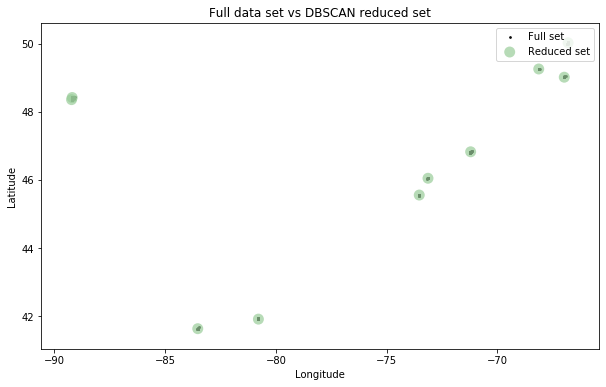

In [18]:
fig, ax = plt.subplots(figsize=[10, 6])
df_scatter = ax.scatter(
    ports['longitude'], ports['latitude'], c='k', alpha=0.9, s=3)
rs_scatter = ax.scatter(
    centroids['centroid_lon'], centroids['centroid_lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], [
          'Full set', 'Reduced set'], loc='upper right')
plt.show()